In [1]:
!pip install qiskit
!pip install qiskit-optimization
!pip install qiskit-ibm-runtime
!pip install pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136818 sha256=9d95a329187145ca2f53a4829c3257a91ced883f5b93021d43ddfaebad431bf0
  Stored in directory: /root/.cache/pip/wheels/d3/31/8b/e09b0386afd80cfc556c00408c9aeea5c35c4d484a9c762fd5
Successfully built pylatexenc


In [2]:
import networkx as nx
from qiskit import execute, Aer, QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.visualization import plot_histogram, plot_bloch_multivector

In [3]:
graph = nx.Graph()
graph.add_nodes_from([0,1,2])
graph.add_edges_from([(0,1),(1,2)])

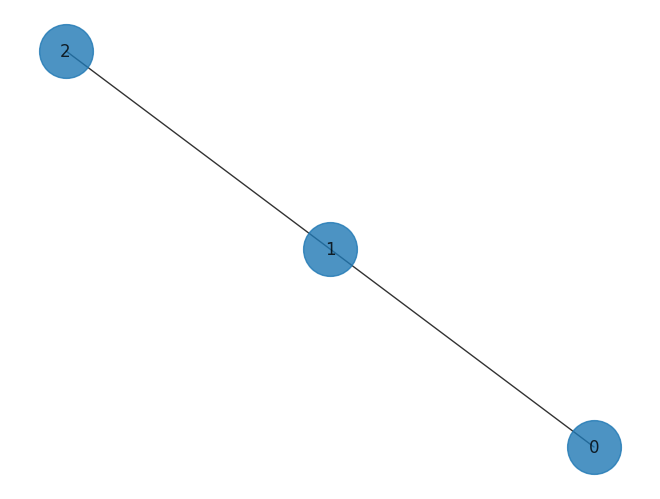

In [4]:
nx.draw(graph, with_labels=True, alpha=0.8, node_size=1500)

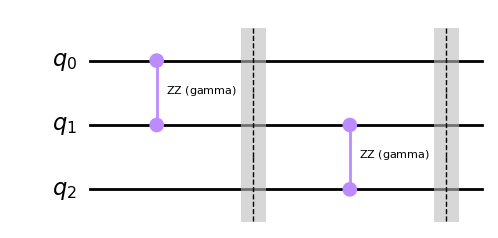

In [5]:
from qiskit.circuit import Parameter

def problem_circuit(graph, gamma):

    qc_p = QuantumCircuit(len(graph.nodes()))
    for edge in list(graph.edges()):
        qc_p.rzz(gamma, edge[0], edge[1])
        qc_p.barrier()

    return qc_p

gamma = Parameter("gamma")
qc_p = problem_circuit(graph, gamma)
qc_p.draw("mpl")

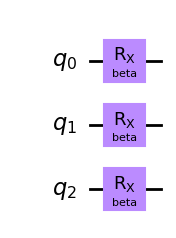

In [6]:
def ansatz_circuit(graph, beta):
    qc_a = QuantumCircuit(len(graph.nodes()))
    for i in range(len(graph.nodes())):
        qc_a.rx(beta, i)

    return qc_a

beta = Parameter("beta")
ansatz_circuit(graph, beta).draw("mpl")

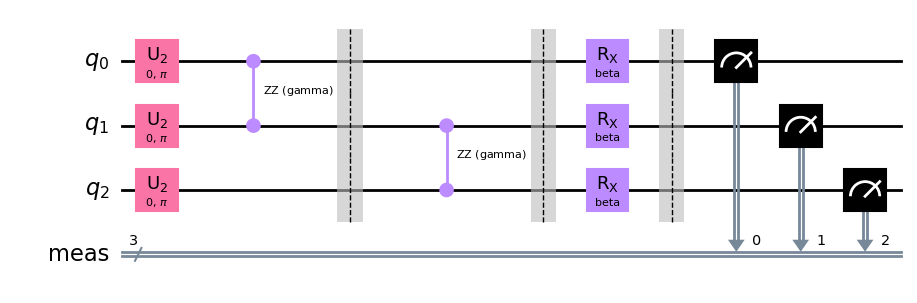

In [7]:
def get_circuit(graph, beta, gamma):
    cnt_qubits = len(graph.nodes())
    qc_qaoa = QuantumCircuit(cnt_qubits)

    # initial_state
    qc_qaoa.h(range(cnt_qubits))

    # append problem circuit
    qc_qaoa.append(problem_circuit(graph, gamma), range(cnt_qubits))

    # append ansatz circuit
    qc_qaoa.append(ansatz_circuit(graph, beta), range(cnt_qubits))

    qc_qaoa.measure_all()
    return qc_qaoa

beta = Parameter("beta")
gamma = Parameter("gamma")
get_circuit(graph, beta, gamma).decompose().draw("mpl")

In [8]:
def get_expectation(counts, graph):
    avg = 0
    sum_count = 0
    for solution, count in counts.items():
        performance = 0
        for i, j in graph.edges():
            if solution[i] != solution[j]:
                performance -= 1

        avg += performance * count
        sum_count += count
    return avg/sum_count

In [10]:
!pip install qiskit-aer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 32.4 MB/s eta 0:00:00


In [11]:
from scipy.optimize import minimize
from qiskit.visualization import plot_histogram

def calculate_circ(graph, beta, gamma, backend, shots):
    qc = get_circuit(graph, beta, gamma)
    result = execute(qc,backend, shots=shots).result()
    return get_expectation(result.get_counts(), graph)

def qaoa(graph):
    backend = Aer.get_backend('qasm_simulator')

    result = minimize(
        # callable function
        lambda thetas: calculate_circ(graph, thetas[0], thetas[1], backend,
                                      1000),
        # initial guess on beta and gamma
        [1.0, 1.0],
        # optimization method
        method='COBYLA')

    return result

result = qaoa(graph)
print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.609
       x: [ 2.358e+00  8.858e-01]
    nfev: 28
   maxcv: 0.0


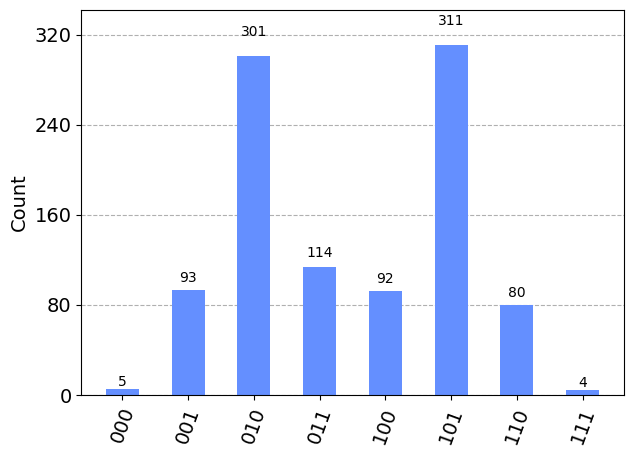

In [12]:
qc_res = get_circuit(graph, result.x[0], result.x[1])
counts = execute(qc_res, Aer.get_backend('qasm_simulator'), shots=1000).result().get_counts()
plot_histogram(counts)

### Using Qiskit to directly solve Maxcut problem

In [13]:
from qiskit_optimization.applications import Maxcut
from qiskit.utils import QuantumInstance
from qiskit import Aer
import pandas as pd

In [14]:
hero_network = pd.read_csv("hero-network.csv")
hero_network.head()

,hero1,hero2
0,"LITTLE, ABNER",PRINCESS ZANDA
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
3,"LITTLE, ABNER",PRINCESS ZANDA
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL


In [19]:
heroes = {'MEDUSA/MEDUSALITH AM','ARCLIGHT/PHILLIPA SO','WOLVERINE/LOGAN ','SCARLET WITCH/WANDA ',
          'ARAGORN','OVERMIND/GROM',}
relations = hero_network[(hero_network.hero1.isin(heroes)) & (hero_network.hero2.isin(heroes))]
relations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87 entries, 895 to 569649
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   hero1   87 non-null     object
 1   hero2   87 non-null     object
dtypes: object(2)
memory usage: 2.0+ KB


In [20]:
%run cred.sh

In [21]:
graph = nx.from_pandas_edgelist(relations, source='hero1', target='hero2')
matrix = nx.to_pandas_adjacency(graph, dtype=int)
adjacency = matrix.to_numpy()

max_cut = Maxcut(adjacency)

qp = max_cut.to_quadratic_program()
qubitOp, offset = qp.to_ising()

#backend = Aer.get_backend("statevector_simulator")
backend = service.backend("ibm_lagos")
quantum_instance = QuantumInstance(backend)

<ipython-input-21-734131e91a89>:12: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend)


In [22]:
from qiskit.algorithms import QAOA
from qiskit_optimization.algorithms import MinimumEigenOptimizer

qaoa = QAOA(quantum_instance=quantum_instance)

# create minimum eigen optimizer based on qaoa
qaoa_optimizer = MinimumEigenOptimizer(qaoa)

# solve quadratic program
print(qaoa_optimizer.solve(qp))

<ipython-input-22-d80056b4290a>:4: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.qaoa.QAOA`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.QAOA``. See https://qisk.it/algo_migration for a migration guide.
  qaoa = QAOA(quantum_instance=quantum_instance)


QiskitError: ignored